# Quantum Fourier Transformation aproximada y ADD aproximada en el algoritmo de Shor.
---

Autor: Alejandro Mata Ali

En este notebook vamos a estudiar el efecto de una implementación aproximada de la transformada cuántica de Fourier (QFT) y de la puerta adición ($\phi ADD$) al algoritmo de Shor.

El estudio se basará en ver los efectos de realizar la Transformada Cuántica de Fourier y la ADD solo usando las fases más significativas, truncando las más pequeñas.

Las principales motivaciones de este estudio son:
* El elevado costo computacional que supone la QFT en el cálculo del algoritmo de Shor (igualmente la ADD).
* El elevado número de puertas que hay que utilizar, ya que en la realidad cada una lleva un error asociado.
* La precisión a la hora de implementar las puertas de fase, que no podrán llegar a fases arbitrariamente pequeñas.


El paper básico que se sigue en la creación de puertas es: https://arxiv.org/abs/quant-ph/0205095, de Stéphane Beauregard.[1]

Una explicación del algoritmo de Shor: https://hmong.es/wiki/Shor%27s_algorithm [2]

Explicación del IQPE: 
https://doi.org/10.48550/arXiv.quant-ph/0001066 [3]

Explicación seminario del autor: https://youtu.be/AJqLk4-tzcc

---
### Paquetes.

Los paquetes que necesitaremos son los siguientes:
* numpy (1.21.5): librería básica para ciertas constantes como $\pi$ o funciones para el cálculo de números binarios (floor y log2).
* pandas (1.4.2): librería para el procesamiento de resultados en forma de tabla y mejorar los análisis.
* matplotlib.pyplot (3.5.1): paquete para poder realizar gráficas.
* scipy (1.7.3): librería para realizar ajustes de datos simulados a funciones.
* qat.lang.AQASM (2.1.3): módulo para la creación y ejecución de los circuitos cuánticos.
* qat.qpus : paquete para obtener la qpu.
* QQuantLib: los módulos phase_estimation_wqft y iterative_quantum_pe del paquete PhaseEstimation, y solver y data_extracting del paquete Utils de esta librería. Se puede encontrar en el enlace de GitHub https://github.com/NEASQC/FinancialApplications. Además usamos el módulo Shor para las funciones implementadas en el anterior notebook.

In [1]:
#Visualizacion y calculo.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as scop
#Cuantico
from qat.lang.AQASM import *
from qat.qpus import get_default_qpu
#Libreria externa para realizar la QFT
from QQuantLib.PE.Shor import *
from QQuantLib.PE.aprox_phase_estimation_wqft import PhaseEstimationwQFTaprox
from QQuantLib.PE.iterative_quantum_pe import IterativeQuantumPE
from QQuantLib.utils.data_extracting import get_results

Username:  tec_app3
 ··········


---
## Funciones y puertas.

Vamos a empezar el estudio observando la función $\phi ADD(a)$ que ya vimos en el anterior Notebook. La usaremos para ver cuán bien 'desempaqueta' la QFT aproximada los números que tiene dentro. Para ello empecemos estudiando la QFT exacta.

In [2]:
@build_gate('QFT', [int], arity=lambda n: n)
def QFT_exact(n):
    '''Funcion que implementa la Quantum Fourier Transformation exacta.
    Su parametro de entrada es el numero de qbits implicados.'''
    routine = QRoutine()
    
    x = routine.new_wires(n)
    for i in range(n):
        routine.apply(H, x[i])
        for j in range(i+1, n):
            routine.apply(PH(np.pi/2**(j-i)).ctrl(), x[j], x[i])
            
    return routine

In [3]:
gate = QFT_exact(3)
%qatdisplay gate --depth 1 --svg

Como podemos observar, el procedimiento de la QFT es el siguiente:

Empezamos con el qbit más significativo aplicando una puerta H. Luego aplicamos puertas de fase controladas por cada uno de los qbits inferiores $q_j$ cada una con una fase $\frac{\pi}{2^{j}}$.

Repetimos el proceso para cada uno de los qbits $q_i$ yendo del más significativo al menos significativo, con las fases controladas $\frac{\pi}{2^{j-i}}$.

---
## Puerta QFT aproximada.

Ahora vamos a implementar la puerta QFT aproximada. La clave de esta puerta está en que solo usaremos las fases que sean superiores a $\frac{\pi}{2^{aprox}}$.

Esto está motivado en los 3 siguientes motivos:
* Las fases van siendo cada vez más pequeñas con $2^{j-i}$, por lo que para qbits muy alejados, la contribución es muy pequeña.
* Reducimos mucho el número de puertas y, más importante aún, el número de interacciones no locales. Esto reduce notablemente el ruido debido al error de las puertas, ya que evitamos además muchas puertas SWAP.
* Reducimos la longitud del circuito, lo cual consigue que se pueda ejecutar mucho más rápido.

In [4]:
@build_gate('QFT', [int, int], arity=lambda n, aprox: n)
def QFT_aprox(n, aprox = 3):
    '''Funcion que implementa la Quantum Fourier Transformation aproximada.
    Sus parametros de entrada son el numero de qbits implicados n y la maxima distancia aprox
    que permitimos para las puertas de fase controladas.'''
    routine = QRoutine()
    
    x = routine.new_wires(n)
    for i in range(n):
        routine.apply(H, x[i])
        for j in range(i+1, n):
            if (j-i) < aprox:
                routine.apply(PH(np.pi/2**(j-i)).ctrl(), x[j], x[i])
            
    return routine

In [5]:
gate = QFT_aprox(4, 2)
%qatdisplay gate --depth 1 --svg

---
## Prueba inicial

Aplicamos $QFT_{aprox}-ADD_{exacta}-QFT^{-1}_{aprox}$

Vamos a comprobar cuanto reduce la precisión el quitar algunas interacciones. Vamos a usar 2 números para hacer una suma de 5 qbits con una aproximación de 3 qits.

Valor obtenido:  44  Real:  44
Probabilidad:  0.8365756555029263


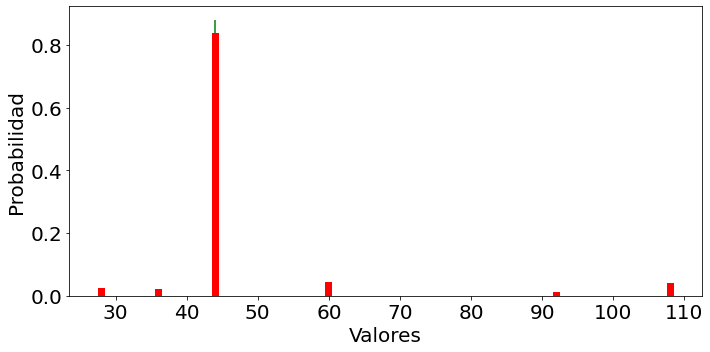

In [30]:
#Creamos el programa y ponemos los parametros a usar.
qprog = Program()

aprox = 3
a = 9
x_val = 35
n = 1 + int(np.floor(np.log2(max([x_val, a])))); n +=1

#----------------------------------------
#Inicializamos el estado de entrada
xbin = numbin(x_val, n)
x = qprog.qalloc(n)
for i in range(n):
    if xbin[i] == '1': qprog.apply(X, x[i])
    
#----------------------------------------
#Aplicamos las puertas
qprog.apply(QFT_aprox(n, aprox), x)
qprog.apply(add_g(n, numbin(a, n)), x)
qprog.apply(QFT_aprox(n, aprox).dag(), x)

#----------------------------------------
#Ejecutamos
circuit = qprog.to_circ(); qpu = get_default_qpu(); job = circuit.to_job()
# Mandamos el trabajo a la qpu
result = qpu.submit(job)

#----------------------------------------
#Extraemos resultados
res =  [ _.probability for _ in result ] 
stat = [ int(str(_.state)[1:n+1], 2) for _ in result]

print('Valor obtenido: ', stat[res.index(max(res))], ' Real: ', a+x_val)
print('Probabilidad: ', max(res) )

#----------------------------------------
#Eliminamos los valores demasiado pequeños para poder observar bien.
i = 0
while i<len(res):
    if res[i] < 0.01:
        res.pop(i); stat.pop(i)
    else: i += 1

#----------------------------------------
#Graficamos.
plt.figure(figsize=(10, 5))
plt.vlines((a+x_val), max(res), max(res)*1.05, color = 'green')
plt.bar(stat, res, width=1, color='red')
plt.xlabel('Valores', fontsize = 20); plt.ylabel('Probabilidad', fontsize = 20)
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.tight_layout(); plt.show()

Como podemos observar, quitando 2 qbits obtenemos una precisión del 84%, teniendo el resultado correcto. Cabe destacar que la distribución no es gaussiana, debido al tipo de sistema que tenemos.

---
## Valores ideales de aproximación.

Vamos a tratar de encontrar los valores ideales para tener una cierta precisión en nuestra operación con el menor número de interacciones posible.

Para ello crearemos una función que explorará tanto los qbits de entrada b, como los valores que vamos a sumarle y las aproximaciones posibles. Nos devolverá la primera iteración en la cual se cumpla que la probabilidad del resultado correcto sea superior a la precisión que le exigimos.

Así, exigiremos que al menos en el 95% de los casos el resultado obtenido con el circuito aproximado $QFT_{aprox}-ADD-QFT^{-1}_{aprox}$ sea igual al obtenido con el circuito exacto $QFT-ADD-QFT^{-1}$.

In [12]:
def busca_aprox(a_range, b_range, precision = 0.85):
    '''Funcion que se encargara de buscar para que valores de aproximacion
    el valor correcto de la suma tiene una probabilidad igual o superior a precision.
    a_range y b_range son unas listas de la forma [inicio, fin, paso]'''
    
    #----------------------------------------
    #Creamos las listas donde vamos a almacenar los valores finales.
    a_values = []; b_values = []; n_values = []
    aprox_values = []; prob_values = []
    
    #Ejecutamos bucles para recorrer las posibles combinaciones de a, b y aprox.
    for a in range(a_range[0], a_range[1], a_range[2]):
        print(a, end=", ")
        for b in range(b_range[0], b_range[1], b_range[2]):
            #Preparacion de parametros.
            n = 2 + int(np.floor(np.log2(max([a, b]))))
            abin = numbin(a, n)
            bbin = numbin(b, n)
            checker = 0         #Checker para saber si es el primer valor que supera la precisión.
            for aprox in range(1, n):
                if checker == 0:
                    #Algoritmo.
                    qprog = Program()
                    x = qprog.qalloc(n)
                    for i in range(n):
                        if bbin[i] == '1': qprog.apply(X, x[i])
                        
                    qprog.apply(QFT_aprox(n, aprox), x)
                    qprog.apply(add_g(n, abin), x)
                    qprog.apply(QFT_aprox(n, aprox).dag(), x)

                    circuit = qprog.to_circ(); qpu = get_default_qpu(); job = circuit.to_job()
                    result = qpu.submit(job)
                    res =  [ _.probability for _ in result ]
                    stat = [ int(str(_.state)[1:n+1], 2) for _ in result]
                    
                    #Condicion de precision y de acierto.
                    if max(res) >= precision and int(stat[res.index(max(res))]) == int(a+b):
                        a_values.append(a); b_values.append(b); n_values.append(n)
                        aprox_values.append(aprox); prob_values.append(max(res))
                        checker = 1
        
    return a_values, b_values, n_values, aprox_values, prob_values

Empezaremos yendo de 1 a 100.

In [7]:
a_values, b_values, n_values, aprox_values, prob_values = busca_aprox([1, 100, 3], [1, 100, 4], precision = 0.95)

1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88, 91, 94, 97, 

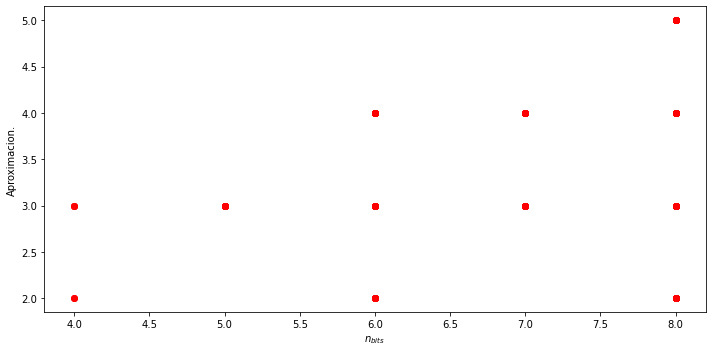

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(n_values, aprox_values, 'o',  color='red')
plt.xlabel('$n_{bits}$'); plt.ylabel('Aproximacion.')
plt.tight_layout(); plt.show()

Podemos observar un crecimiento más lento que una recta. Pasemos a 1 a 1000.

In [9]:
a_values, b_values, n_values, aprox_values, prob_values = busca_aprox([1, 1000, 30], [1, 1000, 41], precision = 0.95)

1, 31, 61, 91, 121, 151, 181, 211, 241, 271, 301, 331, 361, 391, 421, 451, 481, 511, 541, 571, 601, 631, 661, 691, 721, 751, 781, 811, 841, 871, 901, 931, 961, 991, 

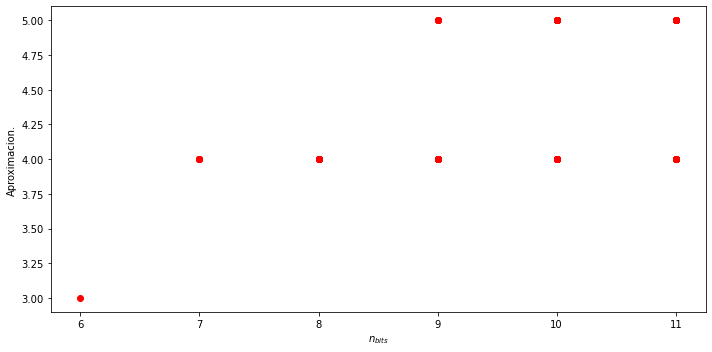

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(n_values, aprox_values, 'o',  color='red')
plt.xlabel('$n_{bits}$'); plt.ylabel('Aproximacion.')
plt.tight_layout(); plt.show()

Vemos que podemos llegar a usar menos de la mitad de las interacciones. Pasemos a 1 a 10000.

In [11]:
a_values, b_values, n_values, aprox_values, prob_values = busca_aprox([1, 10000, 295], [1, 10000, 321], precision = 0.95)

1, 296, 591, 886, 1181, 1476, 1771, 2066, 2361, 2656, 2951, 3246, 3541, 3836, 4131, 4426, 4721, 5016, 5311, 5606, 5901, 6196, 6491, 6786, 7081, 7376, 7671, 7966, 8261, 8556, 8851, 9146, 9441, 9736, 

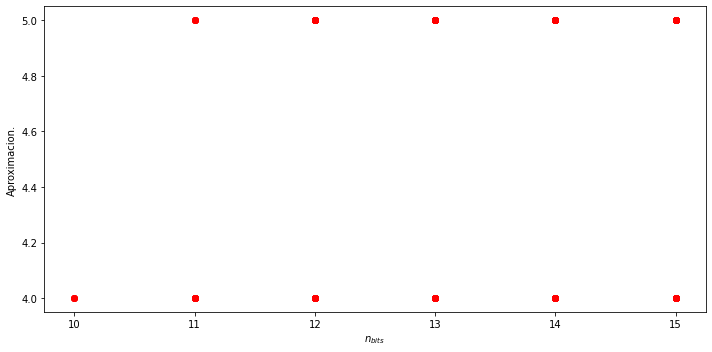

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(n_values, aprox_values, 'o',  color='red')
plt.xlabel('$n_{bits}$'); plt.ylabel('Aproximacion.')
plt.tight_layout(); plt.show()

---
Parece que ahora la tasa de aumento es mucho más lenta, pudiendo quedarnos en 5. Finalmente miremos para 1 a 100000.

In [13]:
a_values, b_values, n_values, aprox_values, prob_values = busca_aprox([1, 100000, 2957], [1, 100000, 3219], precision = 0.95)

1, 2958, 5915, 8872, 11829, 14786, 17743, 20700, 23657, 26614, 29571, 32528, 35485, 38442, 41399, 44356, 47313, 50270, 53227, 56184, 59141, 62098, 65055, 68012, 70969, 73926, 76883, 79840, 82797, 85754, 88711, 91668, 94625, 97582, 

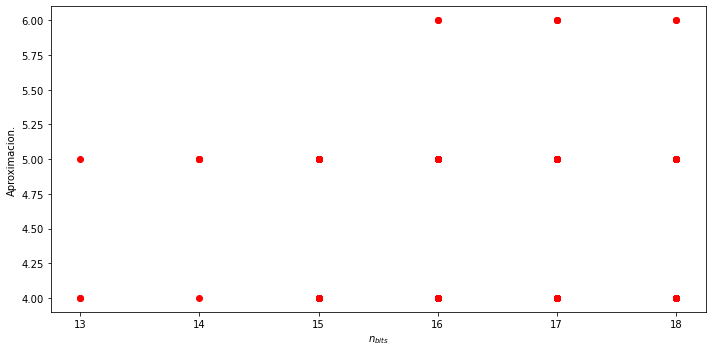

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(n_values, aprox_values, 'o',  color='red')
plt.xlabel('$n_{bits}$'); plt.ylabel('Aproximacion.')
plt.tight_layout(); plt.show()

---
Ahora vamos a intentar definir una función que nos diga qué aproximación utilizar en cada caso. Por seguridad, usaremos siempre el valor más alto de la aproximación para cada caso.

Para ello, recurriremos a una gráfica con los datos obtenidos y un ajuste mediante curve_fit de scipy a una función.

In [6]:
n_val = np.array([4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
aprox = np.array([3, 3, 4, 4, 5, 5,  5,  5,  5,  5,  5,  5,  6,  6,  6])

Como podemos observar un crecimiento más lento que una recta, vamos a utilizar la función logaritmo de la siguiente forma:

a =  1.3891559377173377
b =  1.8924226047825636
c =  0.6037805550896767


C:\Users\tec_app3\AppData\Local\Temp\ipykernel_14044\4202239806.py:3: RuntimeWarning: invalid value encountered in log
  return a + b*np.log(c*x)


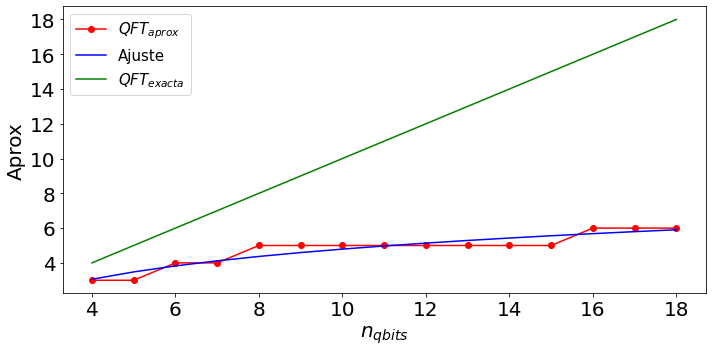

In [9]:
#Funcion a ajustar
def func(x, a, b, c):
    return a + b*np.log(c*x)
#Declaramos el ajuste y nos devuelve los parametros.
ajuste = scop.curve_fit(func, n_val, aprox, p0 = [2, 1, 1])
a, b, c = ajuste[0] #Parametros de ajuste.

print('a = ', a)
print('b = ', b)
print('c = ', c)

#Grafica
plt.figure(figsize=(10, 5))
plt.plot(n_val, aprox, 'o-',  color='red', label='$QFT_{aprox}$')
plt.plot(n_val, [ func(i, a, b, c) for i in n_val] , '-',  color='blue', label='Ajuste')
plt.plot(n_val, n_val , '-',  color='green', label='$QFT_{exacta}$')

plt.xlabel('$n_{qbits}$', fontsize=20); plt.ylabel('Aprox', fontsize=20)
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.legend(loc='upper left', fontsize = 15)
plt.tight_layout(); plt.show()

Ahora miramos el número de puertas totales que consume el caso exacto frente al aproximado.

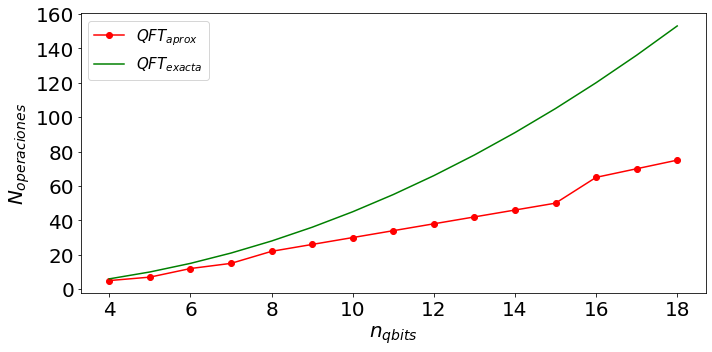

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(n_val, (aprox-1)*(n_val-aprox) + aprox*(aprox-1)/2, 'o-',  color='red', label='$QFT_{aprox}$')
plt.plot(n_val, n_val*(n_val-1)/2 , '-',  color='green', label='$QFT_{exacta}$')
plt.xlabel('$n_{qbits}$', fontsize=20); plt.ylabel('$N_{operaciones}$', fontsize=20)
#plt.yscale('log')
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.legend(loc='upper left', fontsize = 15)
plt.tight_layout(); plt.show()

Vemos que ambas curvas se van separando, creciendo mucho más lentamente la aproximada que la exacta.

Podemos ver que se ajusta perfectamente, por lo que vamos a hacer un redondeo de la siguiente forma:

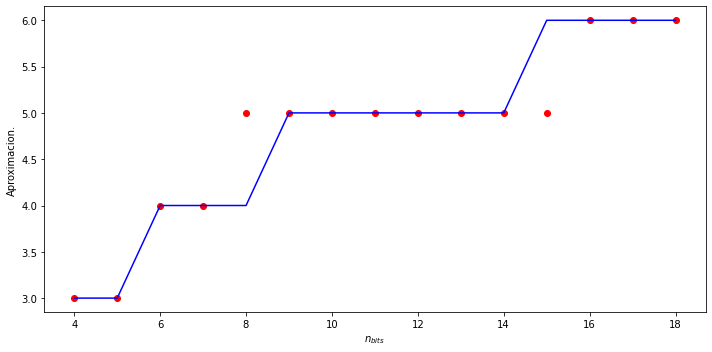

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(n_val, aprox, 'o',  color='red')
plt.plot(n_val, [ np.round(func(i, a, b, c)) for i in n_val] , '-',  color='blue')
plt.xlabel('$n_{bits}$'); plt.ylabel('Aproximacion.')
plt.tight_layout(); plt.show()

---
## $\phi ADD(a)$ aproximada

Vamos a hacer el mismo tipo de aproximación que con la QFT, pero esta vez en la función $\phi ADD(a)$.

In [13]:
@build_gate('ADD_ap', [int, str, int], arity=lambda n, a, aprox: n)
def add_g_aprox(n, a, aprox = 3):
    '''Implementacion de la puerta phiADD(a) con n qbits.
    phi(b) -> phi(b+a)
    a es el binario del numero a implementar.
    aprox es el maximo exponente que puede tener el factor 2 del denominador.'''
    #-------------------------------------
    routine = QRoutine()
    #-------------------------------------
    b = routine.new_wires(n)#Lineas de entrada.
    
    #-------------------------------------
    #Ejecutamos la adicion.
    for i in range(n):#Objetivo
        angle = sum( np.array( [ int(a[j])/2**(j-i) for j in range(i, n) if (j-i)<aprox ] ) )
        if angle != 0: routine.apply( PH(np.pi*angle), b[i] )
    
    return routine

In [14]:
gate = add_g_aprox(4, '1011', 2)
%qatdisplay gate --depth 1 --svg

---
## Pruebas iniciales.

Vamos a repetir el mismo tipo de pruebas que antes, primero con la QFT exacta y luego con la QFT aproximada.

### Con QFT exacta. $QFT_{exacta}-ADD_{aprox}-QFT^{-1}_{exacta}$

Valor obtenido:  47  Real:  47
Probabilidad:  0.8808817253813104


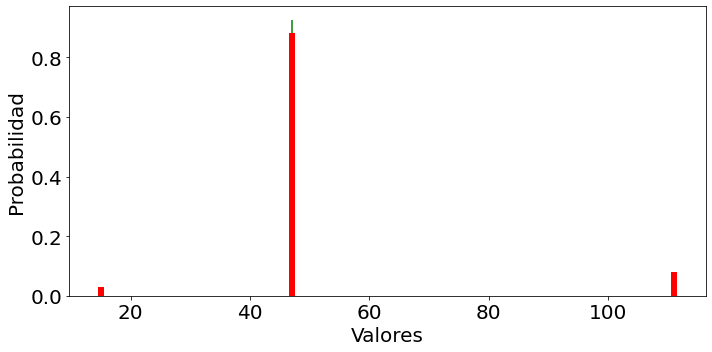

In [31]:
#Creamos el programa y ponemos los parametros a usar.
qprog = Program()

aprox = 3
a = 12
x_val = 35
n = 1 + int(np.floor(np.log2(max([x_val, a])))); n +=1

#----------------------------------------
#Inicializamos el estado de entrada
xbin = numbin(x_val, n)
x = qprog.qalloc(n)
for i in range(n):
    if xbin[i] == '1': qprog.apply(X, x[i])
    
#----------------------------------------
#Aplicamos las puertas
qprog.apply(QFT_exact(n), x)
qprog.apply(add_g_aprox(n, numbin(a, n), aprox), x)
qprog.apply(QFT_exact(n).dag(), x)

#----------------------------------------
#Ejecutamos
circuit = qprog.to_circ(); qpu = get_default_qpu(); job = circuit.to_job()
# Mandamos el trabajo a la qpu
result = qpu.submit(job)

#----------------------------------------
#Extraemos resultados
res =  [ _.probability for _ in result ] 
stat = [ int(str(_.state)[1:n+1], 2) for _ in result]

print('Valor obtenido: ', stat[res.index(max(res))], ' Real: ', a+x_val)
print('Probabilidad: ', max(res) )

#----------------------------------------
#Eliminamos los valores demasiado pequeños para poder observar bien.
i = 0
while i<len(res):
    if res[i] < 0.02: res.pop(i); stat.pop(i)
    else: i += 1

#----------------------------------------
#Graficamos.
plt.figure(figsize=(10, 5))
plt.vlines((a+x_val), max(res), max(res)*1.05, color = 'green')
plt.bar(stat, res, width=1, color='red')
plt.xlabel('Valores', fontsize = 20); plt.ylabel('Probabilidad', fontsize = 20)
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.tight_layout(); plt.show()

Valor obtenido:  480  Real:  480
Probabilidad:  0.8907947380093085


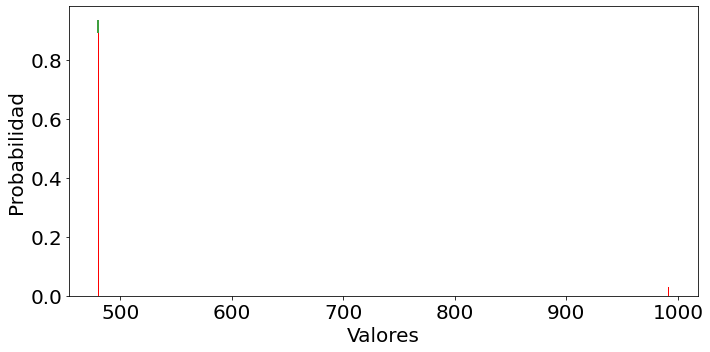

In [32]:
#Creamos el programa y ponemos los parametros a usar.
qprog = Program()

aprox = 4
a = 123
x_val = 357
n = 1 + int(np.floor(np.log2(max([x_val, a])))); n +=1

#----------------------------------------
#Inicializamos el estado de entrada
xbin = numbin(x_val, n)
x = qprog.qalloc(n)
for i in range(n):
    if xbin[i] == '1': qprog.apply(X, x[i])
    
#----------------------------------------
#Aplicamos las puertas
qprog.apply(QFT_exact(n), x)
qprog.apply(add_g_aprox(n, numbin(a, n), aprox), x)
qprog.apply(QFT_exact(n).dag(), x)

#----------------------------------------
#Ejecutamos
circuit = qprog.to_circ(); qpu = get_default_qpu(); job = circuit.to_job()
# Mandamos el trabajo a la qpu
result = qpu.submit(job)

#----------------------------------------
#Extraemos resultados
res =  [ _.probability for _ in result ] 
stat = [ int(str(_.state)[1:n+1], 2) for _ in result]

print('Valor obtenido: ', stat[res.index(max(res))], ' Real: ', a+x_val)
print('Probabilidad: ', max(res) )

#----------------------------------------
#Eliminamos los valores demasiado pequeños para poder observar bien.
i = 0
while i<len(res):
    if res[i] < 0.02: res.pop(i); stat.pop(i)
    else: i += 1

#----------------------------------------
#Graficamos.
plt.figure(figsize=(10, 5))
plt.vlines((a+x_val), max(res), max(res)*1.05, color = 'green')
plt.bar(stat, res, width=1, color='red')
plt.xlabel('Valores', fontsize = 20); plt.ylabel('Probabilidad', fontsize = 20)
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.tight_layout(); plt.show()

Podemos observar que la aproximación sigue siendo buena aquí.

Aún así, contamos con fenómenos de bitflip que pueden llegar a ser importantes en posteriores puertas.

### Con QFT aproximada. $QFT_{aprox}-ADD_{aprox}-QFT^{-1}_{aprox}$

Valor obtenido:  47  Real:  47
Probabilidad:  0.9253281139039601


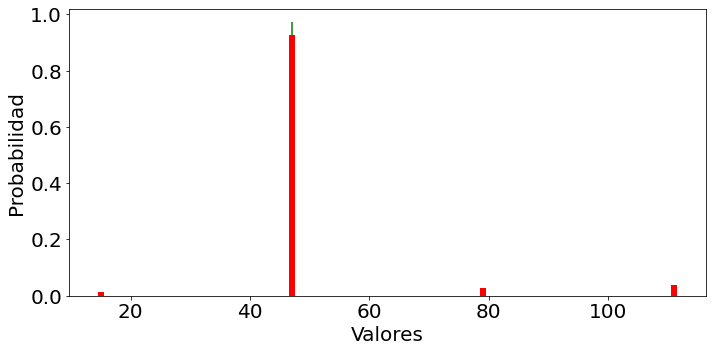

In [15]:
#Creamos el programa y ponemos los parametros a usar.
qprog = Program()

aprox1 = 3
aprox2 = 4

a = 12
x_val = 35
n = 1 + int(np.floor(np.log2(max([x_val, a])))); n +=1

#----------------------------------------
#Inicializamos el estado de entrada
xbin = numbin(x_val, n)
x = qprog.qalloc(n)
for i in range(n):
    if xbin[i] == '1': qprog.apply(X, x[i])
    
#----------------------------------------
#Aplicamos las puertas
qprog.apply(QFT_aprox(n, aprox1), x)
qprog.apply(add_g_aprox(n, numbin(a, n), aprox2), x)
qprog.apply(QFT_aprox(n, aprox1).dag(), x)

#----------------------------------------
#Ejecutamos
circuit = qprog.to_circ(); qpu = get_default_qpu(); job = circuit.to_job()
# Mandamos el trabajo a la qpu
result = qpu.submit(job)

#----------------------------------------
#Extraemos resultados
res =  [ _.probability for _ in result ] 
stat = [ int(str(_.state)[1:n+1], 2) for _ in result]

print('Valor obtenido: ', stat[res.index(max(res))], ' Real: ', a+x_val)
print('Probabilidad: ', max(res) )

#----------------------------------------
#Eliminamos los valores demasiado pequeños para poder observar bien.
i = 0
while i<len(res):
    if res[i] < 0.01:
        res.pop(i); stat.pop(i)
    else: i += 1

#----------------------------------------
#Graficamos.
plt.figure(figsize=(10, 5))
plt.vlines((a+x_val), max(res), max(res)*1.05, color = 'green')
plt.bar(stat, res, width=1, color='red')
plt.xlabel('Valores', fontsize = 20); plt.ylabel('Probabilidad', fontsize = 20)
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.tight_layout(); plt.show()

Valor obtenido:  90  Real:  90
Probabilidad:  0.8535533905932717


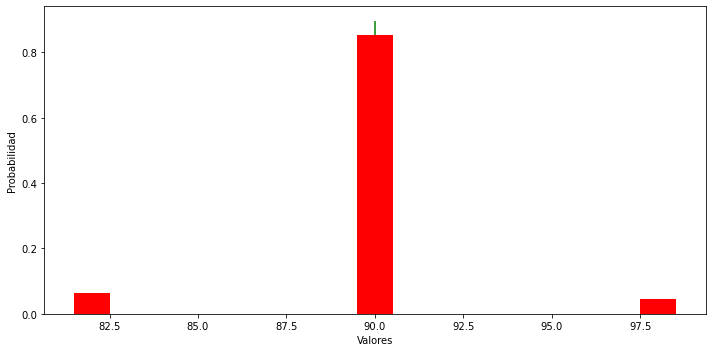

In [16]:
#Creamos el programa y ponemos los parametros a usar.
qprog = Program()

aprox1 = 3
aprox2 = 3

a = 65
x_val = 25
n = 1 + int(np.floor(np.log2(max([x_val, a])))); n +=1

#----------------------------------------
#Inicializamos el estado de entrada
xbin = numbin(x_val, n)
x = qprog.qalloc(n)
for i in range(n):
    if xbin[i] == '1': qprog.apply(X, x[i])
    
#----------------------------------------
#Aplicamos las puertas
qprog.apply(QFT_aprox(n, aprox1), x)
qprog.apply(add_g_aprox(n, numbin(a, n), aprox2), x)
qprog.apply(QFT_aprox(n, aprox1).dag(), x)

#----------------------------------------
#Ejecutamos
circuit = qprog.to_circ(); qpu = get_default_qpu(); job = circuit.to_job()
# Mandamos el trabajo a la qpu
result = qpu.submit(job)

#----------------------------------------
#Extraemos resultados
res =  [ _.probability for _ in result ] 
stat = [ int(str(_.state)[1:n+1], 2) for _ in result]

print('Valor obtenido: ', stat[res.index(max(res))], ' Real: ', a+x_val)
print('Probabilidad: ', max(res) )

#----------------------------------------
#Eliminamos los valores demasiado pequeños para poder observar bien.
i = 0
while i<len(res):
    if res[i] < 0.01:
        res.pop(i); stat.pop(i)
    else: i += 1

#----------------------------------------
#Graficamos.
plt.figure(figsize=(10, 5))
plt.vlines((a+x_val), max(res), max(res)*1.05, color = 'green')
plt.bar(stat, res, width=1, color='red')
plt.xlabel('Valores'); plt.ylabel('Probabilidad')
plt.tight_layout(); plt.show()

Obviamente, con las dos aproximaciones juntas obtenemos peores resultados. Sin embargo, podemos observar que la aproximación de la QFT tiene un mayor impacto, lo cual es razonable.

---
# Operador $U_a$ aproximado.

Ahora vamos a implementar el operador de Shor con las puertas aproximadas que hemos visto.

In [17]:
def m_inv(a, N):
    '''Funcion que implementa a modulo inverso de N.'''
    for _ in range(1, N):#Recorremos todos los numeros entre 1 y N.
        if ((a%N) * (_%N)) % N == 1: return _#Si es el inverso, devolvemos el resultado y acabamos.
    raise Exception('La inversa modulo no existe.')# Por si no existiese dicho numero.

@build_gate('ADDmod_ap', [int, str, str, int, int], arity=lambda n, a, N, aprox1, aprox2: n)
def addmod_g_aprox(n, a, N, aprox1, aprox2):
    '''Implementacion de la puerta phiADD(a)mod(N) con n qbits.
    phi(b) -> phi((b+a)mod(N))
    a y N son los binarios del numero a implementar.
    aprox1 es el numero de aproximacion de la puerta ADD y aprox2 el de la QFT.'''
    #-------------------------------------
    routine = QRoutine()
    #-------------------------------------
    b  = routine.new_wires(n)#Lineas de entrada.
    a0 = routine.new_wires(1); routine.set_ancillae(a0)#Ancilla de control del bit mas significativo.
    
    #-------------------------------------
    #Aplicamos el algoritmo:
    #Suma a, resta N, QFT-1, sacamos el mas significativo, QFT, suma N
    routine.apply(add_g_aprox(n, a, aprox1), b)
    
    routine.apply(add_g_aprox(n, N, aprox1).dag(), b)
    routine.apply(QFT_aprox(n, aprox2).dag(), b)
    routine.apply(CNOT, b[0], a0)
    routine.apply(QFT_aprox(n, aprox2), b)
    routine.apply(add_g_aprox(n, N, aprox1).ctrl(), a0, b)
    
    
    #-------------------------------------
    #Resta a, QFT-1, significativo, QFT, suma a
    routine.apply(add_g_aprox(n, a, aprox1).dag(), b)
    
    routine.apply(QFT_aprox(n, aprox2).dag(), b)
    routine.apply(X, b[0]); routine.apply(CNOT, b[0], a0); routine.apply(X, b[0])
    routine.apply(QFT_aprox(n, aprox2), b)
    
    routine.apply(add_g_aprox(n, a, aprox1), b)
    
    return routine

@build_gate('CMULT_ap', [int, str, str, int, int], arity=lambda n, a, N, aprox1, aprox2: 2*n )
def cmult_g_aprox(n, a, N, aprox1, aprox2):
    '''Implementacion de la puerta phiCMULT(a)mod(N) con n qbits.
    b -> (b+a*x)mod(N)
    a y N son los binarios del numero a implementar.
    Entra primero X y despues b.
    aprox1 es el numero de aproximacion de la puerta ADD y aprox2 el de la QFT.'''
    #-------------------------------------
    routine = QRoutine()
    #-------------------------------------
    x = routine.new_wires(n)#Entrada x (primero).
    b = routine.new_wires(n)#Entrada b (segundo).
    
    #-------------------------------------
    #Transformada, conjunto de sumas, Antitransformada.
    routine.apply(QFT_aprox(n, aprox2), b)
    #Empezamos en el 0 (mas signif) y vamos bajando.
    for i in range(0, n):#Control.
        for j in range(0, int(2**i)):#Numero de aplicaciones.
            routine.apply( addmod_g_aprox(n, a, N, aprox1, aprox2).ctrl(), x[-i-1], b )
    routine.apply(QFT_aprox(n, aprox2).dag(), b)
    
    return routine

@build_gate('U_ap', [int, int, int, int, int], arity=lambda n, a, N, aprox1, aprox2: n)
def ua_g_aprox(n, a, N, aprox1, aprox2):
    '''Implementacion de la puerta phiCMULT(a)mod(N) con n qbits.
    x -> (a*x)mod(N)
    a y n son enteros.
    aprox1 es el numero de aproximacion de la puerta ADD y aprox2 el de la QFT.'''
    #-------------------------------------
    #Preparamos los parametros y los binarios.
    abin = numbin(a, n)
    ainv = numbin(m_inv(a, N), n)#a inverso modulo N
    Nbin = numbin(N, n)
    
    #-------------------------------------
    routine = QRoutine()
    #-------------------------------------
    x  = routine.new_wires(n)#Linea de entrada.
    a0 = routine.new_wires(n); routine.set_ancillae(a0)#Ancillas a 0.
    
    #-------------------------------------
    #Aplicamos el algoritmo:
    #Multiplicamos, swap, dividimos.
    routine.apply(cmult_g_aprox(n, abin, Nbin, aprox1, aprox2), x+a0)
    for i in range(n): routine.apply(SWAP, x[i], a0[i])
    routine.apply(cmult_g_aprox(n, ainv, Nbin, aprox1, aprox2).dag(), x+a0)
    
    return routine

---
## Pruebas iniciales.

Vamos a comprobar qué error sufre la puerta.

Valor obtenido:  38  Real:  38
Probabilidad:  0.15111060861089087


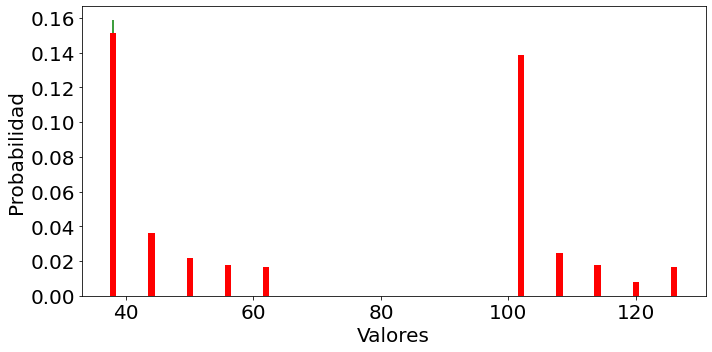

In [18]:
#Creamos el programa y ponemos los parametros a usar.
qprog = Program()

aprox1 = 6    #ADD
aprox2 = 7    #QFT

a = 25
x_val = 34
N = 58
n = 1 + int(np.floor(np.log2(max([x_val, a, N])))); n +=1

#----------------------------------------
#Inicializamos el estado de entrada
xbin = numbin(x_val, n)
x = qprog.qalloc(n)
for i in range(n):
    if xbin[i] == '1': qprog.apply(X, x[i])
    
#----------------------------------------
#Aplicamos las puertas
qprog.apply(ua_g_aprox(n, a, N, aprox1, aprox2), x)

#----------------------------------------
#Ejecutamos
circuit = qprog.to_circ(); qpu = get_default_qpu(); job = circuit.to_job()
# Mandamos el trabajo a la qpu
result = qpu.submit(job)

#----------------------------------------
#Extraemos resultados
res =  [ _.probability for _ in result ] 
stat = [ int(str(_.state)[1:n+1], 2) for _ in result]

print('Valor obtenido: ', stat[res.index(max(res))], ' Real: ', (a*x_val)%N)
print('Probabilidad: ', max(res) )

#----------------------------------------
#Eliminamos los valores demasiado pequeños para poder observar bien.
i = 0
while i<len(res):
    if res[i] < 0.001: res.pop(i); stat.pop(i)
    else: i += 1

#----------------------------------------
#Graficamos.
plt.figure(figsize=(10, 5))
plt.vlines((a*x_val)%N, max(res), max(res)*1.05, color = 'green')
plt.bar(stat, res, width=1, color='red')
plt.xlabel('Valores', fontsize = 20); plt.ylabel('Probabilidad', fontsize = 20)
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.tight_layout(); plt.show()

Podemos observar haciendo pruebas que no podemos reducir la precisión de la puerta ADD, pero sí podemos disminuir unos 2 qbits la QFT de forma asumible.
Esto es debido (a primer orden) a un bitflip en el qbit más significativo, el cual por la operación modular que estamos realizando, siempre debería de ser 0.

---
## CMULT
Vamos a buscar la causa del problema, lo cual nos remite a la puerta anterior, la CMULT. La ejecutamos y observamos los resultados.

Valor obtenido:  17  Real:  17
Probabilidad:  0.8326093377874774


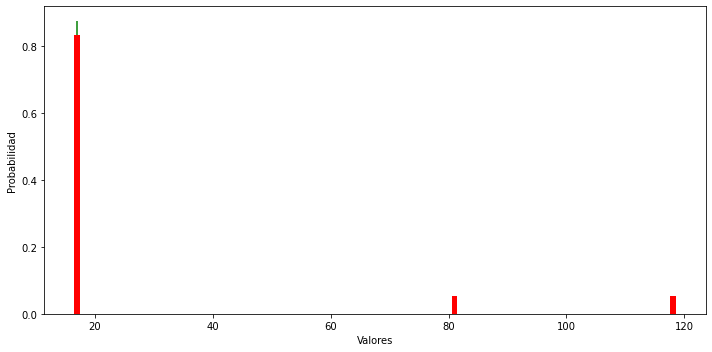

In [19]:
#Creamos el programa y ponemos los parametros a usar.
qprog = Program()

aprox1 = 6
aprox2 = 7

a = 19
b_val = 7
x_val = 20
N = 37
n = 1 + int(np.floor(np.log2(max([x_val, a, N, b_val])))); n +=1

abin = numbin(a, n)
#ainv = numbin(m_inv(a, N), n)#a inverso modulo N
Nbin = numbin(N, n)

#----------------------------------------
#Inicializamos el estado de entrada
xbin = numbin(x_val, n)
x = qprog.qalloc(n)
for i in range(n):
    if xbin[i] == '1': qprog.apply(X, x[i])
    
bbin = numbin(b_val, n)
b = qprog.qalloc(n)
for i in range(n):
    if bbin[i] == '1': qprog.apply(X, b[i])

#----------------------------------------
#Aplicamos las puertas
qprog.apply(cmult_g_aprox(n, abin, Nbin, aprox1, aprox2), [x, b])

#----------------------------------------
#Ejecutamos
circuit = qprog.to_circ(); qpu = get_default_qpu(); job = circuit.to_job()
# Mandamos el trabajo a la qpu
result = qpu.submit(job)

#----------------------------------------
#Extraemos resultados
res =  [ _.probability for _ in result ] 
stat = [ int(str(_.state)[n+3:n+3+n], 2) for _ in result]

print('Valor obtenido: ', stat[res.index(max(res))], ' Real: ', (b_val + a*x_val)%N)
print('Probabilidad: ', max(res) )

#----------------------------------------
#Eliminamos los valores demasiado pequeños para poder observar bien.
i = 0
while i<len(res):
    if res[i] <= 0.01: res.pop(i); stat.pop(i)
    else: i += 1

#----------------------------------------
#Graficamos.
plt.figure(figsize=(10, 5))
plt.vlines((b_val + a*x_val)%N, max(res), max(res)*1.05, color = 'green')
plt.bar(stat, res, width=1, color='red')
plt.xlabel('Valores'); plt.ylabel('Probabilidad')
plt.tight_layout(); plt.show()

Podemos ver que el efecto mayoritario de error proviene de un bitflip en el qbit más significativo, el cual debería ser cero. Una forma de arreglar esta situación sería convertir este bit a 1 con algún sistema controlado, pero es complicada la implementación. La propuesta que parece lógica es usar una ancilla a la cual haremos SWAP con este qbit y así sacar del sistema dicho error. Sin embargo, sigue teniendo el problema de tener la ancilla 'contaminada'.

---
## $U_a$ aproximada 'corregida'.

Proponemos la siguiente implementación de la puerta $U_a$, aunque no la usaremos en los análisis posteriores.

In [20]:
@build_gate('U_ap2', [int, int, int, int, int], arity=lambda n, a, N, aprox1, aprox2: n)
def ua_g_aprox2(n, a, N, aprox1, aprox2):
    '''Implementacion de la puerta phiCMULT(a)mod(N) con n qbits.
    x -> (a*x)mod(N)
    a y n son enteros.
    aprox1 es el numero de aproximacion de la puerta ADD y aprox2 el de la QFT.'''
    #-------------------------------------
    #Preparamos los parametros y los binarios.
    abin = numbin(a, n)
    ainv = numbin(m_inv(a, N), n)#a inverso modulo N
    Nbin = numbin(N, n)
    
    #-------------------------------------
    routine = QRoutine()
    #-------------------------------------
    x  = routine.new_wires(n)#Linea de entrada.
    a0 = routine.new_wires(n); routine.set_ancillae(a0)#Ancillas a 0.
    a1 = routine.new_wires(2); routine.set_ancillae(a1)#Ancilla a del flip.
    
    #-------------------------------------
    #Aplicamos el algoritmo:
    #Multiplicamos, swap, dividimos.
    routine.apply(cmult_g_aprox(n, abin, Nbin, aprox1, aprox2), x+a0)
    routine.apply(SWAP, a1[0], a0[0])
    
    for i in range(n): routine.apply(SWAP, x[i], a0[i])
    routine.apply(cmult_g_aprox(n, ainv, Nbin, aprox1, aprox2).dag(), x+a0)
    routine.apply(SWAP, a1[1], a0[0])
    
    return routine

In [21]:
gate = ua_g_aprox2(4, 2, 5, 2, 1)
%qatdisplay gate --depth 1 --svg

Valor obtenido:  38  Real:  38
Probabilidad:  0.19461535848714206


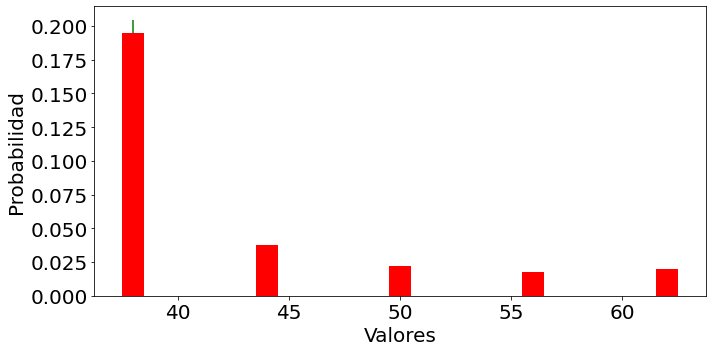

In [22]:
#Creamos el programa y ponemos los parametros a usar.
qprog = Program()

aprox1 = 6    #ADD
aprox2 = 7    #QFT

a = 25
x_val = 34
N = 58
n = 1 + int(np.floor(np.log2(max([x_val, a, N])))); n +=1

#----------------------------------------
#Inicializamos el estado de entrada
xbin = numbin(x_val, n)
x = qprog.qalloc(n)
for i in range(n):
    if xbin[i] == '1': qprog.apply(X, x[i])
    
#----------------------------------------
#Aplicamos las puertas
qprog.apply(ua_g_aprox2(n, a, N, aprox1, aprox2), x)

#----------------------------------------
#Ejecutamos
circuit = qprog.to_circ(); qpu = get_default_qpu(); job = circuit.to_job()
# Mandamos el trabajo a la qpu
result = qpu.submit(job)

#----------------------------------------
#Extraemos resultados
res =  [ _.probability for _ in result ] 
stat = [ int(str(_.state)[1:n+1], 2) for _ in result]
ancilla = [ int(str(_.state)[n+7: n+7+n], 2) for _ in result]
print('Valor obtenido: ', stat[res.index(max(res))], ' Real: ', (a*x_val)%N)
print('Probabilidad: ', max(res) )

#----------------------------------------
#Eliminamos los valores demasiado pequeños para poder observar bien.
i = 0
while i<len(res):
    if res[i] < 0.01:
        res.pop(i); stat.pop(i); ancilla.pop(i)
    else: i += 1

#----------------------------------------
#Graficamos.
plt.figure(figsize=(10, 5))
plt.vlines((a*x_val)%N, max(res), max(res)*1.05, color = 'green')
plt.bar(stat, res, width=1, color='red')
plt.xlabel('Valores', fontsize = 20); plt.ylabel('Probabilidad', fontsize = 20)
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.tight_layout(); plt.show()

Podemos observar que el problema ha sido parcialmente resuelto.

---
# Shor aproximado

Ahora vamos a ejecutar el algoritmo de Shor con la puerta $U_a$ sin corregir para observar los resultados.

In [16]:
import time
from QQuantLib.utils.qlm_solver import get_qpu
QLMaaS = True
linalg_qpu = get_qpu(QLMaaS)#Esta linea adquiere el resolvedor que le hayamos especificado.

Using: LinAlg


Esta función nos permitirá ejecutar el algoritmo para distintas aproximaciones.

In [17]:
def Shor_ap(p, q, shots = 8, method = 'QPE', used_a = [], aprox = [3, 3], a = 0):
    '''Funcion que implementa todo el algoritmo de Shor para un par p, q de
    numeros primos enteros dados. Se puede cambiar el numero de shots.
    method es el metodo de resolucion a usar.
    Si ponemos QPE usara el quantum phase estimation with QFT.
    Si ponemos IQPE usara el Iterative Quantum Phase Estimation.
    used_a es una lista de valores de a que no queremos que aparezcan.
    aprox es la aproximacion que vamos a usar para las ADD y las QFT, respectivamente.
    a es un indicador de si queremos introducir manualmente el valor de a.'''
    
    #-------------------------------------
    if a == 0: a, N = primador(p, q, used_a = used_a)
    else: N = p * q
    #Determinamos el numero de qbits.
    n = 2 + int(np.floor(np.log2(N)))
    n_cbits = n #El mismo para los clasicos.
    print('a = ', a, ', N = ', N, ', n = ', n, ', aprox = ', aprox)
    
    #Nuestra puerta de Shor.
    unitary_operator = ua_g_aprox(n, a, N, aprox[0], aprox[1])
    #-------------------------------------
    #Estado inicial.
    initial_state = QRoutine()
    x = initial_state.new_wires(n)
    initial_state.apply(X, x[-1])#Estado 1.
    
    
    #Diccionario de Python para la configuracion.
    config_dict = {
    'initial_state': initial_state,
    'unitary_operator': unitary_operator,
    'qpu' : linalg_qpu,
    'auxiliar_qbits_number' : n_cbits,  
    'shots': shots,
    'aprox': aprox[1]
    }
    
    if method == 'QPE':
        qft_pe = PhaseEstimationwQFTaprox(**config_dict)
        start = time.time()
        qft_pe.pe_wqft()#La enviamos a ejecutar
        stop = time.time()
        print('Tiempo de ejecución: ', stop - start)
        Resultados = qft_pe.final_results.loc[qft_pe.final_results['Probability'] > 0]
        Valores    = [ int(_) for _ in Resultados['Int'] ]
        Probabilidad = np.array([ _ for _ in Resultados['Probability'] ])*100#Por ser porcentual
    
    elif method == 'IQPE':
        iqpe_ = IterativeQuantumPE(**config_dict)
        start = time.time()
        iqpe_.iqpe()
        stop = time.time()
        print('Tiempo de ejecución: ', stop - start)
        Resultados = iqpe_.sumarize(iqpe_.final_results, 'BitInt')
        Valores    = [ int(_) for _ in Resultados['BitInt'] ]
        Probabilidad = np.array([ _ for _ in Resultados['Frequency'] ])
        Probabilidad /= Probabilidad * 100 / sum(Probabilidad)
    
    check = 0
    rs = []#Lista de r obtenidos.
    r_correct = []#Lista de r correctos
    for i in range(len(Valores)):#El 0 no contribuye.
        if Valores[i] != 0:
            r = reductor(Valores[i], 2**n)[1]#El denominador.
            if r not in rs and r % 2 == 0:
                if a**r != -1 % N:
                    rs.append(r)
                    p_obt = np.gcd(int(a**int(r/2) - 1), N);   q_obt = np.gcd(int(a**int(r/2) + 1), N)
                    print('r = ', r, end=', ')
                    if (p == q_obt and q == p_obt) or (p == p_obt and q == q_obt):
                        print('Los primos son: ', p_obt, ', ', q_obt)
                        r_correct.append(r); check += Probabilidad[i]
                    else: print('No se cumple. Los primos obtenidos son: ', p_obt, q_obt)
            elif r in r_correct: check += Probabilidad[i] #Por las repeticiones.
    if check == 0: p_obt = 0; q_obt = 0; print('No encontrados.')
    print('Aciertos = ', check, ' %')
    return Valores, p_obt, q_obt, check, a

---
Vamos a hacer la primera prueba. Para N=15 y la peor aproximación posible.

In [18]:
Valores, p_obt, q_obt, check, a = Shor_ap(3, 5, shots = 100, method = 'QPE', a = 7, aprox = [1,1])

a =  7 , N =  15 , n =  5 , aprox =  [1, 1]
Submitted a new batch: Job7697
Tiempo de ejecución:  8.091929197311401
r =  2, No se cumple. Los primos obtenidos son:  3 1
r =  4, Los primos son:  3 ,  5
Aciertos =  48.0  %


Como se puede observar, tenemos el resultado esperado con la forma exacta.

In [20]:
Valores, p_obt, q_obt, check, a = Shor_ap(3, 5, shots = 100, method = 'QPE', a = 7, aprox = [1,5])

a =  7 , N =  15 , n =  5 , aprox =  [1, 5]
Submitted a new batch: Job7699
Tiempo de ejecución:  8.237078428268433
r =  2, No se cumple. Los primos obtenidos son:  3 1
r =  4, Los primos son:  3 ,  5
r =  8, No se cumple. Los primos obtenidos son:  15 1
r =  16, No se cumple. Los primos obtenidos son:  15 1
r =  32, No se cumple. Los primos obtenidos son:  15 1
Aciertos =  12.0  %


Curiosamente, si no introducimos la misma aproximación en este algoritmo para ADD y para la QFT, reducimos el grado de acierto.

---

In [19]:
Valores, p_obt, q_obt, check, a = Shor_ap(3, 7, shots = 20, method = 'QPE', a = 8, aprox = [6,6])

a =  8 , N =  21 , n =  6 , aprox =  [6, 6]
Submitted a new batch: Job7698
Tiempo de ejecución:  30.91316509246826
r =  2, Los primos son:  7 ,  3
Aciertos =  45.0  %


In [23]:
Valores, p_obt, q_obt, check, a = Shor_ap(3, 7, shots = 20, method = 'QPE', a = 8, aprox = [1,1])

a =  8 , N =  21 , n =  6 , aprox =  [1, 1]
Submitted a new batch: Job7702
Tiempo de ejecución:  16.507364988327026
r =  2, Los primos son:  7 ,  3
Aciertos =  50.0  %


In [21]:
Valores, p_obt, q_obt, check, a = Shor_ap(5, 11, shots = 20, method = 'QPE', a = 34, aprox = [3,3])

a =  34 , N =  55 , n =  7 , aprox =  [3, 3]
Submitted a new batch: Job7700
Tiempo de ejecución:  347.93278074264526
r =  2, Los primos son:  11 ,  5
Aciertos =  55.00000000000001  %


In [22]:
Valores, p_obt, q_obt, check, a = Shor_ap(5, 11, shots = 20, method = 'QPE', a = 34, aprox = [1,1])

a =  34 , N =  55 , n =  7 , aprox =  [1, 1]
Submitted a new batch: Job7701
Tiempo de ejecución:  230.5398290157318
r =  2, Los primos son:  11 ,  5
Aciertos =  45.0  %


In [26]:
itera = 1; check = 0; it_max = 100
used_a = [8, 26, 31, 17, 2, 32, 20, 14, 5]
while check == 0 and itera < it_max:
    Valores, p_obt, q_obt, check, a = Shor_ap(3, 11, shots = 20, method = 'QPE', aprox = [1,1], used_a=used_a)
    used_a.append(a)
    itera += 1

a =  32 , N =  33 , n =  7 , aprox =  [1, 1]
Submitted a new batch: Job7709
Tiempo de ejecución:  165.49015378952026
No encontrados.
Aciertos =  0  %
a =  14 , N =  33 , n =  7 , aprox =  [1, 1]
Submitted a new batch: Job7710
Tiempo de ejecución:  219.39863348007202
r =  2, No se cumple. Los primos obtenidos son:  1 3
r =  4, No se cumple. Los primos obtenidos son:  3 1
No encontrados.
Aciertos =  0  %
a =  20 , N =  33 , n =  7 , aprox =  [1, 1]
Submitted a new batch: Job7711
Tiempo de ejecución:  205.1503176689148
r =  2, No se cumple. Los primos obtenidos son:  1 3
r =  32, No se cumple. Los primos obtenidos son:  3 1
r =  128, No se cumple. Los primos obtenidos son:  3 1
No encontrados.
Aciertos =  0  %
a =  5 , N =  33 , n =  7 , aprox =  [1, 1]
Submitted a new batch: Job7712
Tiempo de ejecución:  208.91724681854248
r =  2, No se cumple. Los primos obtenidos son:  1 3
r =  32, No se cumple. Los primos obtenidos son:  3 1
r =  64, No se cumple. Los primos obtenidos son:  3 1
r =  1

Observamos que en el caso de poner la misma aproximación para la ADD y la QFT, tenemos resultados mucho mejores.

---
# Conclusiones

Hemos podido observar que la QFT aproximada tiene una gran utilidad, ya que nos permite realizar de forma sorprendentemente rápida y precisa a la vez los mismos cálculos que la QFT exacta. Además, cuando la usamos con la misma aproximación que la ADD, obtenemos resultados notablemente buenos.

Sin embargo, vemos necesario:
* Investigar más a fondo el porque funciona esta aproximación en el caso simétrico.
* Investigar si funciona para mayor número de qbits.
* Investigar si es igual de eficiente para números más grandes.